In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from comet_ml import Experiment

import os

import gym
import numpy as np
from gym.spaces.box import Box

from baselines import bench
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

import glob

/home/tyler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tyler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
num_envs = 8
lr               = 2.5e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
save_every_update = 50
gamma = 0.99
tau = 0.95
critic_weight = 1.0
entropy_weight = 0.01
clip_param = 0.1
max_frames  = 5000


render = False

In [4]:
def make_env(env_id, seed, rank):
    def _thunk():
        if env_id.startswith("dm"):
            _, domain, task = env_id.split('.')
            env = dm_control2gym.make(domain_name=domain, task_name=task)
        else:
            env = gym.make(env_id)
        is_atari = hasattr(gym.envs, 'atari') and isinstance(
            env.unwrapped, gym.envs.atari.atari_env.AtariEnv)
        if is_atari:
            # Does some pre-processing that affects pong
            # 1) Samples initial states by taking random number of no-ops
            #    on reset (at most 30)
            # 2) Returns only every 4th frame
            env = make_atari(env_id)
        env.seed(seed + rank)


        if is_atari:
            # Does some pre-processing that affects pong
            # 1) Make end-of-life == end-of-episode, but only reset on true game over
            # 2) Warp frames to 84x84
            # 3) Stack 4 frames
            # 4) Scale the image by dividing by 255
            env = wrap_deepmind(env, frame_stack=True, scale=True)

        return env

    return _thunk


In [5]:
from common.multiprocessing_env import SubprocVecEnv

env_name = "CartPole-v0"
seed = 42


envs = [make_env(env_name, seed, i)
        for i in range(num_envs)]

envs = SubprocVecEnv(envs)

env = gym.make(env_name)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Process Process-4:
Process Process-1:
Process Process-2:
Process Process-6:
Process Process-5:
Process Process-7:
Process Process-8:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6

In [6]:
def init_normc_(weight, gain=1):
    weight.normal_(0, 1)
    weight *= gain / torch.sqrt(weight.pow(2).sum(1, keepdim=True))
    
def init(module, weight_init, bias_init, gain=1):
    weight_init(module.weight.data, gain=gain)
    bias_init(module.bias.data)
    return module

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(ActorCritic, self).__init__()
        
        init_ = lambda m: init(m,
              init_normc_,
              lambda x: nn.init.constant_(x, 0))

        self.actor = nn.Sequential(
            init_(nn.Linear(num_inputs, 64)),
            nn.Tanh(),
            init_(nn.Linear(64, 64)),
            nn.Tanh()
        )

        self.critic = nn.Sequential(
            init_(nn.Linear(num_inputs, 64)),
            nn.Tanh(),
            init_(nn.Linear(64, 64)),
            nn.Tanh()
        )
        
        self.critic_linear = init_(nn.Linear(64, 1))
        self.actor_linear   = init_(nn.Linear(64, num_outputs))
                         
    def forward(self, x):
        value = self.critic_linear(self.critic(x))
        softs = F.softmax(self.actor_linear(self.actor(x)), dim=1)
        dist = Categorical(softs)
        return dist, value

In [7]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [8]:
def compute_gae(next_value, rewards, masks, values, gamma=gamma, tau=tau):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [9]:
num_outputs = envs.action_space.n

model = ActorCritic(4, num_outputs).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-5)

In [10]:
frame_idx    = 0
test_rewards = []

# Important

With GAE: GAE advantage just used for actor loss. Discounted returns used for critic.

In [11]:
## grab random values for each batch
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage, values):
    batch_size = states.size(0)
    sampler = BatchSampler(SubsetRandomSampler(range(batch_size)), 
                           mini_batch_size, 
                           drop_last=False)
    for rand_ids in sampler:
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :], values[rand_ids, :]
        
        
def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, values, clip_param=clip_param):
    for _ in range(ppo_epochs):
        for s, act, lp, r, adv, v in ppo_iter(mini_batch_size, states, actions, log_probs,
                                                                       returns, advantages, values):
            
            act = act.squeeze(1)
            lp = lp.squeeze(1)
            adv = adv.squeeze(1)
            
            new_dist, new_value = model(s)
            new_entropy = new_dist.entropy().mean()
            new_log_prob = new_dist.log_prob(act)            
            ratio = torch.exp(new_log_prob - lp)
            
            surr1 = ratio * adv
            surr2 = torch.clamp(ratio, 1.0 - clip_param,
                                           1.0 + clip_param) * adv
            
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = F.mse_loss(r,new_value)

            optimizer.zero_grad()
            loss = (actor_loss + critic_weight * critic_loss - entropy_weight * new_entropy)
            loss.backward(retain_graph=True)
            optimizer.step()
    return actor_loss, critic_loss, -new_entropy

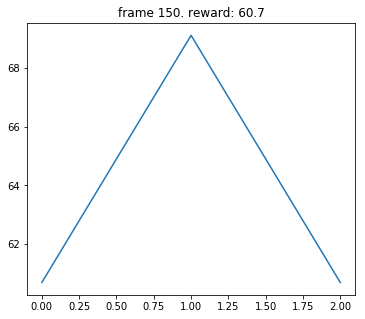

torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Si

KeyboardInterrupt: 

In [12]:
state = envs.reset()
update_iter = 0
test_rewards

while frame_idx < max_frames:
    log_probs = []
    values = []
    rewards = []
    masks = []
    states = []
    actions = []

    
    for step_index in range(num_steps):
        # state is 16 x 4 because 16 envs
        state = torch.FloatTensor(state).to(device)
        states.append(state)
        # dist and value each have 16 for all envs
        dist, value = model(state)
        
        # have 16 actions
        action = dist.sample()
        actions.append(action)
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        log_prob = dist.log_prob(action)

        log_probs.append(log_prob)
        values.append(value)
        # there are 16 rewards. Need to make it 16x1. Same for masks
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
                
        state = next_state
        frame_idx += 1
        
            
        if frame_idx % save_every_update == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)
    
    log_probs = torch.cat(log_probs).unsqueeze(1).to(device)
    returns = torch.cat(returns).detach().to(device)
    values = torch.cat(values).to(device)
    advantages = returns - values
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)
    actions   = torch.cat(actions).unsqueeze(1).to(device)
    states = torch.cat(states).to(device)
                        
    last_al, last_cl, last_el = ppo_update(ppo_epochs, mini_batch_size, states, actions, 
                log_probs, returns, advantages, values)
    
            
    update_iter += 1

In [ ]:
test_env(True)